# What is linear regression?

Linear regression is a machine learning model, where the prediction $y$ is a linear function of the input $x$:

> $y = \theta_1 x + \theta_0$

This is equivalent to:
> $y = \theta_1 x_1 + \theta_0 x_0$ , where $x_0 = 1$. In matrix notation:
>
> $y = \theta^T X$


Let's illustrate with a dataset:

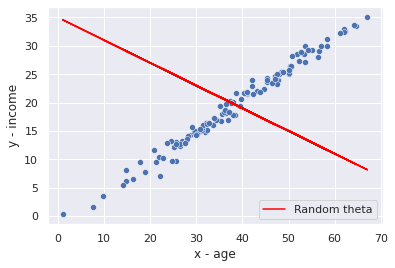

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import jax
import jax.numpy as jnp
from sklearn.datasets import make_regression

def create_dataset():
    X, y = make_regression(n_samples=120, n_features=1, noise=10, random_state=3); X=X.flatten()
    X = (X+3)*13
    y = (y+200) * 0.1
    return X,y

X,y = create_dataset()
ax = sns.scatterplot(x=X, y=y); ax.set_xlabel("x - age"); ax.set_ylabel("y - income")

def to_matrix(X):
    x = np.expand_dims(X,1)
    return np.c_[x, np.ones(x.shape[0])]

def predict(theta, x):
    return np.matmul(x, theta.T)

some_theta = np.array([-0.4, 35.0])
x = to_matrix(X)
y_p1 = predict(some_theta,x)

ax.plot(x[:,0], y_p1, label="Random theta", color="red")
_ = plt.legend()

# Finding the best  $\theta$

Let's explore two different ways:

* A **"closed-form"** solution aka the **normal equation**
* An **iterative approach** aka **gradient descent**

For each one, we need a loss function that we seek to optimize with respect to $\theta$. We will use a mean-squared-error or MSE:

> $J(\theta) = \frac{1}{2m} \sum\limits_{i=1}^m ( \hat{y}(x^{(i)}) - y^{(i)})^2$, where $\hat{y}$ is the predicted value.


## Normal equation (closed form)
This approach uses calculus to find the optimal value of $\theta$, given all the data. Here we won't show [the proof](https://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression/), only the the solution:

> $\theta=(X^TX)^{−1}X^Ty$


Theta:  [ 0.5591123  -1.88165669]
CPU times: user 90.3 ms, sys: 20 ms, total: 110 ms
Wall time: 44.3 ms


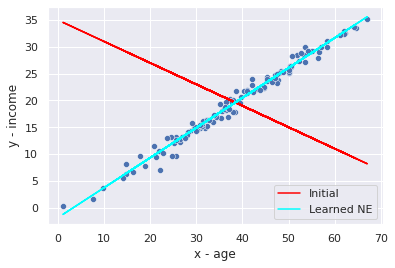

In [54]:
%%time
theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)
print('Theta: ',theta)

y_p2 = predict(theta,x)
ax = sns.scatterplot(x=x[:,0], y=y); ax.set_xlabel("x - age"); ax.set_ylabel("y - income")
ax.plot(x[:,0], y_p1, label="Initial", color="red")
ax.plot(x[:,0], y_p2, label="Learned NE", color="cyan")
legend = plt.legend()


**Pros**: Simple and fast (one iteration)

**Cons**:
* Doesn't scale well with data and number of input features. Inverting a matrix is $O(n^3)$
* **Lacks generality and doesn't work for other model hypotheses e.g. neural nets**

## Gradient descent
Similar results can be achieved passing data in small batches and using gradient of the loss function with respect to $\theta$.


[ 0.552382  -1.5943544]
CPU times: user 42.4 s, sys: 26.4 ms, total: 42.5 s
Wall time: 42.4 s


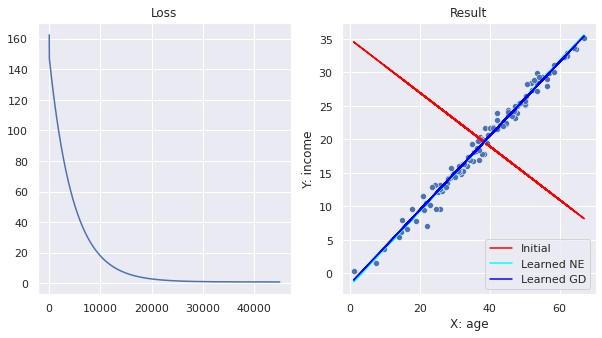

In [66]:
%%time
def predict_jax(theta, x):
    return jnp.matmul(x,theta.T)

@jax.value_and_grad
def loss(theta, x, y):
    y_p = predict_jax(theta, x)
    return jnp.mean(jnp.square(y_p - y))

@jax.jit
def update(theta, x, y, lr):
    loss_val, grads = loss(theta, x, y)
    new_theta = theta - grads*lr
    return loss_val, new_theta

def train(x, y, epochs = 45000, lr=0.0005):
    theta = some_theta # same initial values as before
    losses = jnp.zeros(epochs, dtype=jnp.float32)
    
    for epoch in range(epochs):
        loss_val, theta = update(theta, x, y, lr)
        losses = losses.at[epoch].set(loss_val)
        
    return theta, losses
    

theta, losses = train(x,y)
print(theta)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(losses)
ax1.set_title("Loss")

y_p3 = predict_jax(theta,x)
ax2.set_title("Result")
ax = sns.scatterplot(x=x[:,0], y=y,axes=ax2); ax.set_xlabel("X: age"); ax.set_ylabel("Y: income")

ax.plot(x[:,0], y_p1, label="Initial", color="red")
ax.plot(x[:,0], y_p2, label="Learned NE", color="cyan")
ax.plot(x[:,0], y_p3, label="Learned GD", color="blue")
legend = plt.legend()

## Conclusions
GD is more general but also prone to lots of errors and hyperparameter tuning
- need to tweak/schedule the learning rate
- feature scaling affects numerical stability and training speed (flat landscapes)
- many interations may be needed